# Restaurants market research in Los Angeles.

You’ve decided to open a small robot-run cafe in Los Angeles. The project is promising but expensive, so you and your partners decide to try to attract investors. They’re interested in the current market conditions - will you be able to maintain your success when the novelty of robot waiters wears off?
Your partners have asked you to prepare some market research. You have open-source data on restaurants in LA.

### Table of content <a class="anchor" id="table_of_contents"></a> 
1. [Opening data](#start)
2. [Preprocessing data](#preprocessing)
    * [Processing missing values](#null)
    * [Processing duplicate data](#duplicates) 
    
3. [Data analysis](#analysis)
    * [Proportions of the various types of establishments](#proportions)
    * [Proportions of chain and nonchain establishments](#chain)
    * [Chains analysis](#chains)
    * [Number of seats](#seats)
    * [Streets analysis](#streets)
    
4. [Conclusion](#conclusion)
5. [Presentation](#presentation)
    

### Opening data <a id="start"></a> 

### Need To Install <a class="anchor" id="install"></a>

In [1]:
pip install seaborn -U

Requirement already up-to-date: seaborn in c:\ainna\anaconda\lib\site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.patches as mpatches
from matplotlib import ticker
from matplotlib.ticker import PercentFormatter
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [3]:
# open file
path = 'https://code.s3.yandex.net/datasets/'
name = 'rest_data_us.csv'
data = pd.read_csv(path + name) 
data.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


### Preprocessing data <a id="preprocessing"></a> 

In [4]:
# have a look at file info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


There are 3 missing values in the column 'chain'. These establishments we can check manually whether they are chains or not.

#### Processing missing values <a id="null"></a> 

In [5]:
# show rows with missing values 
data[data['chain'].isnull()]

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35


In [6]:
# create a list with establishment's names with missing values
missing = data[data['chain'].isnull()]['object_name'].tolist()
missing

['TAQUERIA LOS 3 CARNALES', "JAMMIN JIMMY'S PIZZA", 'THE LEXINGTON THEATER']

In [7]:
# check if there are other rows with the same establishments names
data.query('object_name in @missing')

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35


We should check if there are the same establishments but with different name spelling.

In [8]:
# check JAMMIN JIMMY'S PIZZA
data[data["object_name"].str.contains("JAMMIN|JIMMY'S")]

,id,object_name,address,chain,object_type,number
6790,18576,WI JAMMIN CAFE,1359 S REDONDO BLVD,False,Restaurant,28
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1


JAMMIN JIMMY'S PIZZA doesn't have other establishments so this is not a chain. And the restaurant in the Lexington theater definitely not a chain. We can replace missing values by "False". 

In [9]:
# check TAQUERIA LOS 3 CARNALES
data[data["object_name"].str.contains("CARNALES")]

,id,object_name,address,chain,object_type,number
6419,18205,TACOS LOS CARNALES,4370 S CENTRAL AVE,False,Fast Food,47
6624,18410,TACOS LOS 3 CARNALES,5000 WHITTIER BLVD,False,Fast Food,6
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14
9616,21402,TACOS LOS 4 CARNALES,5000 WHITTIER BLVD,False,Fast Food,9


We see three establishments with the same name (but in different wording: Tacos and Taqueria) located at the same address. The only difference is the number of places. We can assume (or check via Google as we have only 1 such case) that TAQUERIA LOS 3 CARNALES is a restaurant with 14 sitting places then we can delete two other rows and fillin missing value in chain column with False value.

In [10]:
# fill in missing values with False
data['chain'] = data['chain'].fillna(False)

# check
data.query('object_name in @missing')

,id,object_name,address,chain,object_type,number
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,False,Restaurant,14
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,False,Pizza,1
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,False,Restaurant,35


#### Processing duplicate data <a id="duplicates"></a> 

In [11]:
# delete two duplicated rows with indexes 6624 and 9616
data = data.drop([data.index[6624], data.index[9616]]).reset_index(drop=True)


In [12]:
# check if there are chain type establishments with different name spelling
data.query('chain == True')['object_name'].unique().tolist()

['ABC DONUTS',
 'EL POLLO LOCO',
 'POONG NYUN BAKERY',
 'EMC RESTAURANT GROUP LLC',
 'CUSCATLECA BAKERY',
 'FOOD COURT TRAY WASHING AREA',
 'M CAFE DE CHAYA',
 "NORM'S RESTAURANT",
 'KRISPY KRUNCHY CHICKEN - ALVARADO',
 'DUNES RESTAURANT',
 'ONO HAWAIIAN BBQ',
 'MUSH BAKERY',
 "REGGIE'S DELI & CAFE",
 'HOT THAI RESTAURANT',
 'WABA GRILL',
 'SUBWAY -52105',
 'IHOP',
 'PANDA EXPRESS #2596',
 'LA MONARCA BAKERY',
 'THE COUNTER SPACE 7C',
 "TOGO'S",
 "JACKY'S RESTAURANT",
 'BASE COAT -JUICE BAR',
 'KIKKA @ ARCO PLAZA',
 "JOHNNIE'S NEW YORK PIZZA",
 'EAGLE ROCK BREWERY',
 'DONUT STAR',
 'ROSE GARDEN CAFE',
 "MCDONALD'S #2084",
 'BLD',
 'LOCALI',
 'SUBWAY #39685',
 'LEMONADE RESTAURANT',
 'LA SIRENA RESTAURANT',
 'JACK IN THE BOX # 335',
 'FOOD PICNIC DAY',
 'JIN RESTAURANT',
 'CELAYA BAKERY',
 'K-BAKERY',
 'LOS PINITOS NUEVOS BAKERY',
 'SHAKE SHACK',
 'JOHNNY ROCKETS',
 "MCDONALD'S # 10129",
 'ZANKOU CHICKEN',
 "JIM'S BURGERS",
 'DER WIENERSCHNITZEL #20',
 'DELICIAS BAKERY AND SOME',
 'TUTT

We see some "big players" with name wording differences, for instance: SUBWAY and SUBWAY SANDWICHES, STURBUCKS and STURBUCKS COFFEE, plus we have numbers of branches or special signs like in MACDONALD'S names. We should clean the data to avoid analyzing chain type establishments separately. Especially we should pay attention to Cafes since this is our main goal of LA market research.

In [13]:
# clean names of the market 'big players'
data['object_name'] = data.object_name.str.replace(r'(^.*STARBUCKS.*$)', 'STARBUCKS')
data['object_name'] = data.object_name.str.replace(r'(^.*COFFEE BEAN.*$)', 'THE COFFEE BEAN AND TEA LEAF')
data['object_name'] = data.object_name.str.replace(r'(^.*PEET.*$)', "PEET'S COFFEE AND TEA")
data['object_name'] = data.object_name.str.replace(r'(^.*RALPHS MARKET.*$)', "RALPHS MARKET")
data['object_name'] = data.object_name.str.replace(r'(^.*MCDONALD.*$)', "MCDONALD'S")
data['object_name'] = data.object_name.str.replace(r'(^.*SUBWAY.*$)', "SUBWAY")
data['object_name'] = data.object_name.str.replace(r'(^.*YOSHINOYA.*$)', "YOSHINOYA")

In [14]:
# delete branches' numbers
data['object_name'] = data['object_name'].replace('[#0-9]+','',regex=True)

In [15]:
# remove leading and trailing whitespaces from strings with object names
data['object_name'] = data.object_name.str.replace(r'(^\s+|\s+$)',"")

In [16]:
# check Cafe category
data.query('chain == True & object_type == "Cafe"')['object_name'].sort_values(ascending=True).unique().tolist()

["ALANA'S COFFEE ROASTING",
 'ANDANTE COFFEE ROASTERS',
 'ANDANTE COFFEE ROASTERS, INC',
 'BLUE BOTTLE COFFEE',
 'BOBA K-TOWN AND COFFEE',
 'BRASIL KISS COFFEE BAR',
 'BREAKROOM COFFEE AND FOOD, INC',
 'COFFE TIME',
 'COFFEE & FOOD',
 'COFFEE COMMISSARY',
 'COFFEE TIME',
 'COFFEE TIMES DONUT',
 'COGNOSCENTI COFFEE',
 'CRAFT COFFEE AND GOOD FOOD CAFE',
 'DRINK COFFEE + TEA',
 'FRANCES BAKERY AND COFFEE',
 'GROUNDWORK COFFEE',
 'GROUNDWORK COFFEE -THE GROVE (KIOSK)',
 'HEALING COFFEE ROASTERS',
 'LOLLICUP TEA & COFFEE ZONE',
 "MARIE'S COFFEE AND DELI",
 'MARU COFFEE',
 'MON DELIZ COFFEE & BAKERY',
 'NAZOHS BAKERY & COFFEE SHOP',
 "PEET'S COFFEE AND TEA",
 'PHILZ COFFEE',
 "PICHILINGUE'S RESTAURANT-COFFEE",
 'RALPHS MARKET',
 'ROCK COFFEE HOUSE',
 'ROCK PAPER COFFEE',
 'SMART & FINAL',
 'SPRING FOR COFFEE',
 'SPRING FOR COFFEE/ SESTAN JUICERY',
 'STARBUCKS',
 'THE COFFEE BEAN AND TEA LEAF',
 'THE COFFEE TABLE EAGLE ROCK',
 'TIERRA MIA COFFEE COMPANY',
 'TOBARA COFFEE AND BAKERY',
 'TOM N 

In [17]:
#check some cafes' names
data[data['object_name'].str.contains("GROUNDWORK")]

,id,object_name,address,chain,object_type,number
4948,16734,GROUNDWORK COFFEE,108 W 2ND ST,True,Cafe,29
5584,17370,GROUNDWORK COFFEE -THE GROVE (KIOSK),189 THE GROVE DRIVE # K2,True,Cafe,10
7761,19548,GROUNDWORK,1501 N CAHUENGA BLVD,False,Restaurant,84
9347,21134,GROUNDWORK COFFEE,150 N LARCHMONT BLVD,True,Cafe,5


In [18]:
#check some cafes' names
data[data['object_name'].str.contains("TOM N TOMS")]

,id,object_name,address,chain,object_type,number
4310,16096,TOM N TOMS COFFEE,333 S ALAMEDA ST STE #108,True,Cafe,112
4831,16617,TOM N TOMS,2716 W OLYMPIC BLVD # 108,True,Restaurant,27
5886,17672,TOM N TOMS-COFFEE,3974 W WILSHIRE BLVD # 101,True,Cafe,78
6393,18179,TOM N TOMS COFFEE,3785 WILSHIRE BLVD STE 26,True,Cafe,1
7091,18878,TOM N TOMS COFFEE,3240 WILSHIRE BLVD STE #102,True,Cafe,12
8567,20354,TOM N TOMS COFFEE,125 N WESTERN AVE # #113,True,Cafe,143
8813,20600,TOM N TOMS VERMONT GALLERIA,440 S VERMONT AVE # 116,True,Restaurant,9
9562,21349,TOM N TOMS,3829 6TH ST,True,Restaurant,2


In [19]:
# replace cafe names
data['object_name'] = data.object_name.str.replace(r'(^.*TOM N TOMS.*$)', 'TOM N TOMS')
data['object_name'] = data.object_name.str.replace(r'(^.*GROUNDWORK COFFEE.*$)', 'GROUNDWORK COFFEE')
data['object_name'] = data.object_name.str.replace(r'(^.*COFFE TIME.*$)', 'COFFEE TIME')
data['object_name'] = data.object_name.str.replace(r'(^.*ANDANTE COFFEE.*$)', 'ANDANTE COFFEE ROASTERS')

The data in object names has been cleaned and we will be able to analyze what characterizes chains: many establishments with a small number of seats or a few establishments with a lot of seats.

###  Data analysis<a id="analysis"></a> 

#### Proportions of the various types of establishments <a id="proportions"></a> 

In [20]:
# calculate proportion of each establishment type

proportions_types = data.groupby('object_type', as_index=False).agg({\
                'object_name': 'count'})

proportions_types.columns = ['type','number']

proportions_types['percent'] = proportions_types['number'] / proportions_types['number'].sum() * 100
proportions_types

,type,number,percent
0,Bakery,283,2.932946
1,Bar,292,3.026220
2,Cafe,435,4.508239
3,Fast Food,1064,11.027049
4,Pizza,320,3.316406
5,Restaurant,7255,75.189139


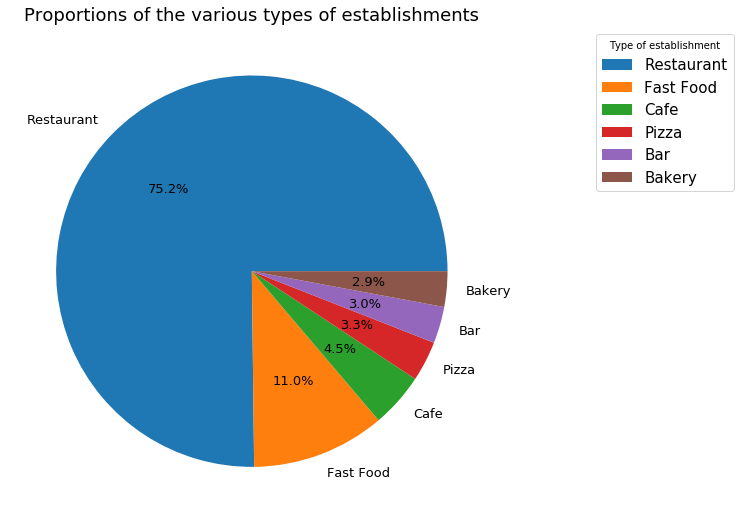

In [21]:
# prepare the data for plotting
# create a dictionary of establishments types and their totals
d = data['object_type'].value_counts().to_dict()

# plot a pie chart 
fig = plt.figure(figsize = (18, 9))
ax = fig.add_subplot()
ax.pie(d.values(),
       labels = d.keys(), 
       autopct = '%1.1f%%',
       textprops = {'fontsize': 13, 'color' : "black"})
 
# set the title
ax.set_title("Proportions of the various types of establishments", fontsize=18)

# set the legend and add a title to the legend
ax.legend(loc = "upper right", bbox_to_anchor = (1, 0, 0.5, 1), fontsize = 15, title = "Type of establishment");
plt.savefig('proportion.png') # save the graph as image for presentation
plt.show()

From the chart we see that restaurants have the largest market share in Los Angeles - over 75%. Fast food establishments have 11% of market and cafes have only 4.5%. That means there is no strong competition in the segment we are interested in. 

#### Proportions of chain and nonchain establishments <a id="chain"></a> 

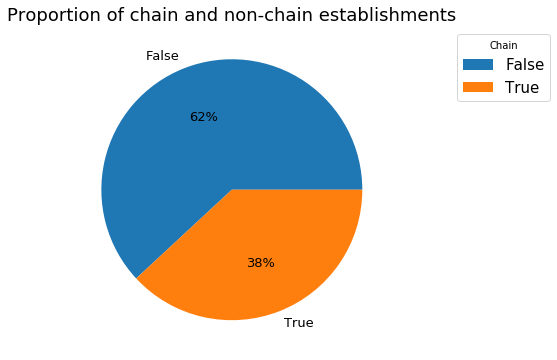

In [22]:
# calculate number of chain and non-chain establishments
chain = data['chain'].value_counts().to_dict()

# plot pie chart
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot()

ax.pie(chain.values(), 
       labels = chain.keys(), 
       autopct = '%1.0f%%', 
       textprops = {'fontsize': 13, 'color' : "black"})

ax.set_title("Proportion of chain and non-chain establishments", size = 18)
ax.legend(loc = "upper right", bbox_to_anchor = (1, 0, 0.5, 1), fontsize = 15, title = "Chain")
plt.savefig('proportion_chain.png')

At first glance, it seems that most of the establishments in LA are non-chain type: 62% while chain type - 38%.
But we should analyse each category.

In [23]:
# define a function to calculate percantage of chain and non-chain establishments in each category
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

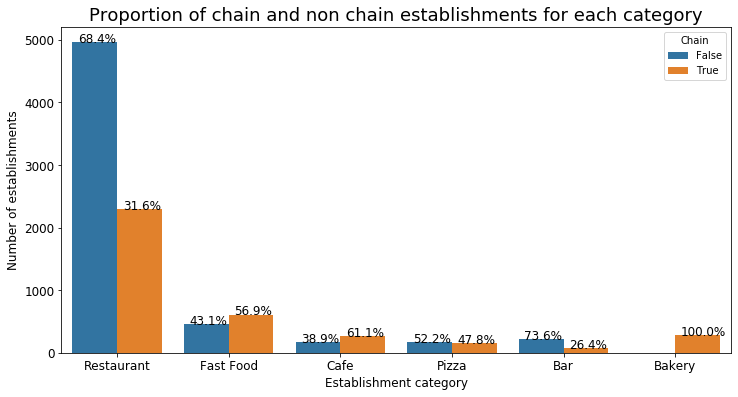

<Figure size 432x288 with 0 Axes>

In [24]:
# plot a graph with proportion of chain and non chain establishments in each category

plt.figure(figsize = (12,6))
category_order = ['Restaurant', 'Fast Food', 'Cafe', 'Pizza', 'Bar', 'Bakery']
ax = sns.countplot('object_type', hue='chain', data=data, order = category_order)
plt.xticks(size=12)
plt.xlabel('Establishment category', size=12)
plt.yticks(size=12)
plt.ylabel('Number of establishments', size=12)
plt.title('Proportion of chain and non chain establishments for each category', size = 18)
ax.legend(loc = 'upper right',title = 'Chain')

with_hue(ax, data.object_type, 6, 2) # calculate proportion
plt.savefig('proportion_by_category.png')
plt.show()

In [25]:
# calculate absolute numbers of chain and non chain establishments in each category 
chain_type = data.pivot_table(index = 'object_type', columns = 'chain', values = 'object_name', aggfunc = 'count', 
                 margins = True, fill_value = 0)
chain_type.columns = ['non_chain', 'chain', 'total']
chain_type

,non_chain,chain,total
object_type,,,
Bakery,0,283,283
Bar,215,77,292
Cafe,169,266,435
Fast Food,459,605,1064
Pizza,167,153,320
Restaurant,4963,2292,7255
All,5973,3676,9649


In LA most restaurants (68%) are non-chain type. The same pattern we see for bars: 74% and 26% respectively. But in Pizza segment there are approximately equal shares: 52% - non-chain types and 48% - chain types. However in Cafe and Fast Food categories chain type establishments predominate. And as we see from the graph all bakeries in LA are chain model.

#### Chains analysis<a id="chains"></a> 

What characterizes chains: many establishments with a small number of seats or a few establishments with a lot of seats?

In [26]:
# have a look on statistical data by the number of seats of chain type establishments

print('The most frequent number of seats is:', data.query('chain==True')['number'].agg('mode').to_string(index=False))
data.query('chain==True')['number'].describe()

The most frequent number of seats is:  12


count    3676.000000
mean       39.694233
std        43.437212
min         1.000000
25%        13.000000
50%        25.000000
75%        44.000000
max       229.000000
Name: number, dtype: float64

From the statistical description we see that chain type establishments tends toward a few number of seats: an average number of seats is about 40 with the large standard deviation of 43. While the most frequent number of seats is 12 and median value - 25 seats. Only 25% of establishments have more than 44 seats. We see than chain type establishments differ a lot: there are small one with 1 seat and some large up to 229 seats.

[Link to installation code](#install)

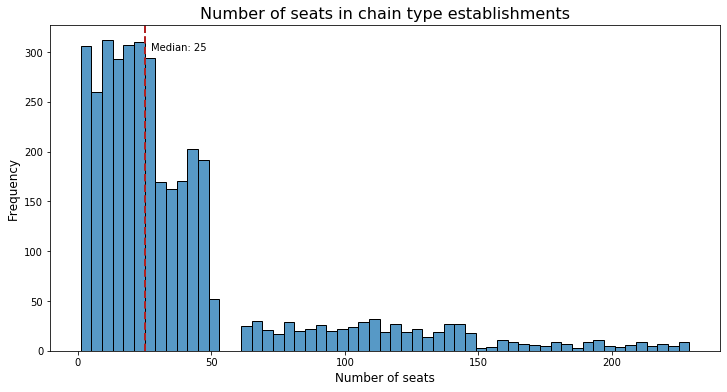

In [27]:
# plot a histogram of seats distribution in chain type establishments
chains_only = data.query('chain==True')
plt.figure(figsize = (12,6))
sns.histplot(chains_only, x='number', bins='auto')
plt.axvline(chains_only['number'].median(), color='firebrick', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(chains_only['number'].median()*1.1, max_ylim*0.92, 'Median: {:.0f}'.format(chains_only['number'].median()))
plt.xlabel("Number of seats", fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title('Number of seats in chain type establishments', size = 16)
plt.savefig('chains_seats.png')
plt.show()

In general, LA chains are characterized by a large number of establishments with a small number of seats. An average number of seats is 25. But there are missing values in range 50-60 seats. Probably this is a boundary between 'few' and 'many' seats numbers. More than that should analyze each chain in each category to understand if this is a trend for every market category.

In [28]:
# choose chain type establishments and check the absence of number of seats in range 50-60
chains_only = data.query('chain==True')

# less than or equal to 50, top 10
print("Less than or equal to 50 seats:",
      chains_only.query('number <=50')['number'].sort_values(ascending=False).head(10).values) 

# seats greater than 50, bottom 10
print("Greater than 50:",chains_only.query('number >50')['number'].sort_values().head(10).values)


Less than or equal to 50 seats: [49 49 49 49 49 49 49 49 49 49]
Greater than 50: [61 61 61 62 62 62 62 62 62 62]


As a result we can set a boundary in number of seats: 'few' - less or equal to 50, 'many' - greater than 50.

In [29]:
# define category of the number of seats
data['seats_category'] = data['number'].apply(
    lambda x: 'few' if x <= 50 else 'many')
data.head()

,id,object_name,address,chain,object_type,number,seats_category
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26,few
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9,few
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,few
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,few
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20,few


In [30]:
# calculate percentage of each seats category in chain type establisments
data[data['chain']==True]['seats_category'].value_counts(normalize=True)

few     0.825082
many    0.174918
Name: seats_category, dtype: float64

In chains 82.5% establishments have a few seats on average and 17.5% - many. We came to main conclusion, in LA chains are characterized by many establishments with few number of seats. But the generalized analysis is made and in order to avoid incorrect conclusions due to paradoxes, we must analyze each category separately.

In [31]:
# choose chain type establishments and calculate their number in a chain and an average number of seats
chains_only = data.query('chain == True').pivot_table(
                                          index=['object_type','object_name'],
                                          aggfunc = {'object_name':'count', 'number':'mean'})
                                       
chains_only.columns = ['seats_avg','number_est'] # change column names: average number of seats in each chain
                                                 # and number of establishments in a chain
chains_only.sort_values(by='number_est',ascending=False).head() # sort chains by size

seats_avg  number_est
object_type object_name                                        
Fast Food   SUBWAY                        17.269737         152
Cafe        STARBUCKS                     27.124031         129
            THE COFFEE BEAN AND TEA LEAF  23.939394          66
Fast Food   MCDONALD'S                    97.580645          62
Restaurant  JACK IN THE BOX               64.980769          52

There are some 'big players' on the LA market: chains with the large number of establishments. For instance Subway has 152 branches in LA, Starbucks has 129 cafes. But their average number of seats is small (17-27), while Mcdonald's for example has less establisments - 62, but they are larger - almost 100 seats.

In [32]:
# calculate average number of establishments and seats in each category
chains_only.groupby('object_type').agg({'number_est':'mean','seats_avg':'median'}).round(0)

,number_est,seats_avg
object_type,,
Bakery,1.0,17.0
Bar,1.0,22.0
Cafe,7.0,20.0
Fast Food,4.0,21.0
Pizza,4.0,18.0
Restaurant,2.0,27.0


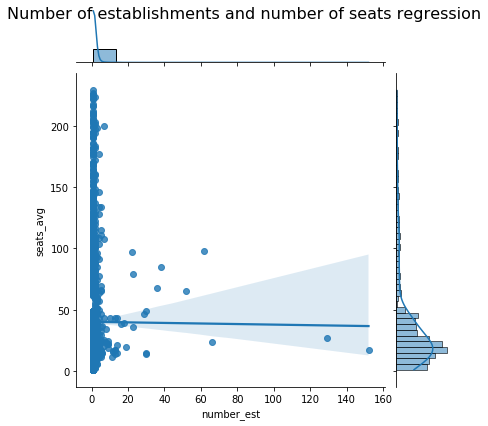

In [33]:
# plot jointplot to analyze how many establishments there are in chains
# a distribution of their average number of seats and regression between these two indicators

sns.jointplot(data=chains_only, x='number_est', y='seats_avg', kind='reg')
plt.xlabel("Number of establishments in a chain", fontsize=12)
plt.ylabel("Average number of seats in a chain",fontsize=12)
plt.suptitle('Number of establishments and number of seats regression', fontsize = 16)

plt.show()

From the graph we can not make a univocal conclusion what characterize chains. We see that on average chains doesn't have many establishments and they don't have a lot of seats. It varies on chain type: whether it is a restaurant or a bakery or cafe, etc. Let's have a look on each category in detail.

Bakery


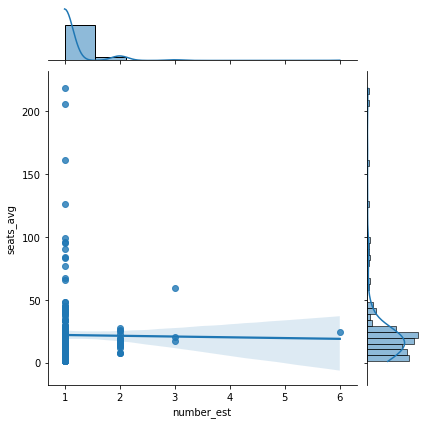

Bar


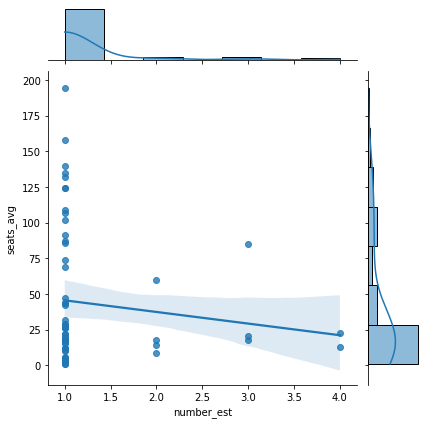

Cafe


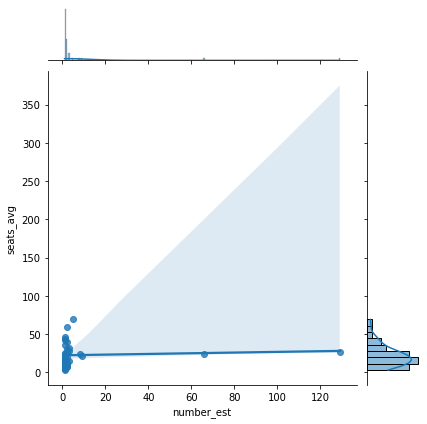

Fast Food


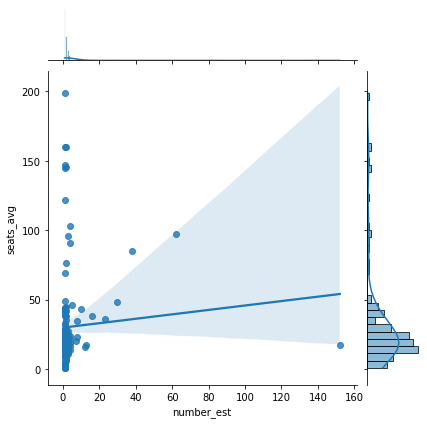

Pizza


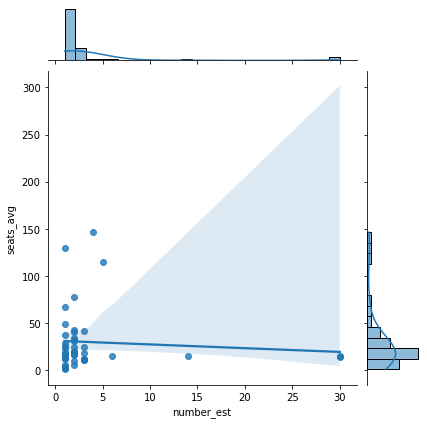

Restaurant


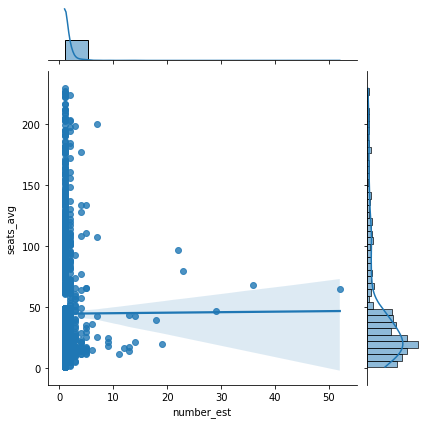

In [34]:
# plot jointplot for each chain category
types = chains_only.reset_index()['object_type'].unique().tolist() # define categories

# create a loop to plot a graph for every category

for i in types:
    slice = chains_only.reset_index()[chains_only.reset_index()['object_type']==i]
    name = i
    print(name)
    sns.jointplot(x='number_est', y='seats_avg', data=slice,kind='reg')
    plt.show()

In LA most chains doesn't have a lot of branches and they are not big: less than 50 seats on average. However in each market segment chains vary. In Bakery and Bar segments chains are small or only one establishment from the chain is represented in LA, but the size of bakery doesn't depend on the number of establishments in the chain, while in Bars category the bigger the chain the smaller the bar. In Cafe segment we can see several huge chains with a lot of establishments, but they have a small number of seats. In Fast Food with the growth of distribution, the size of a network increases. But Pizza type chains on the contrary have a lot of small establishments. In Restaurant category we see a pattern that there are a lot of chains with small number of establishments, but with more sitting seats.

#### Number of seats <a id="seats"></a> 

Determine the average number of seats for each type of restaurant. On average, which type of restaurant has the greatest number of seats?

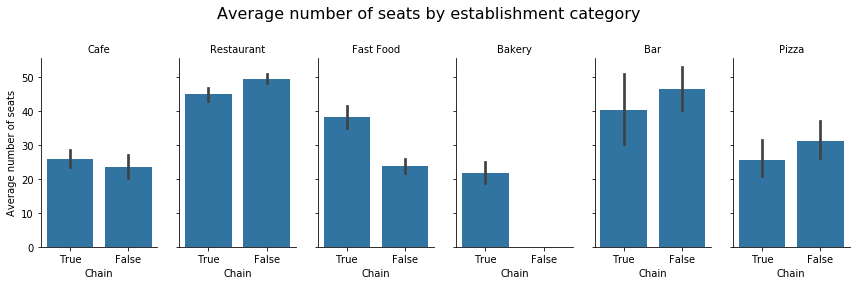

In [35]:
# divide establishments by category and chain type and show average number of seats
g = sns.FacetGrid(data, col="object_type", height=4, aspect=.5)
g.map(sns.barplot, "chain", "number", order=[True,False])
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Average number of seats by establishment category', fontsize=16)
g.set_axis_labels("Chain", "Average number of seats")
g.set_titles(col_template="{col_name}")
plt.savefig('avg_number_seats_by_category.png')
plt.show()

In [36]:
# calculate average number of seats in each category 
seats = data.pivot_table(index='object_type', values='number',columns='chain',\
                         aggfunc='mean',fill_value=0,margins=True).\
                         sort_values(by='All', ascending=False).round(0)
seats

chain,False,True,All
object_type,,,
Restaurant,50.0,45.0,48.0
Bar,46.0,40.0,45.0
All,46.0,40.0,44.0
Fast Food,24.0,38.0,32.0
Pizza,31.0,26.0,28.0
Cafe,24.0,26.0,25.0
Bakery,0.0,22.0,22.0


On average the greatest number of seats have Restaurants of non-chain type - 50 seats and non-chain Bars - 46 seats. The smallest establishments are bakeries - 22 seats on average.

In [37]:
# calculate proportions of small and big establishments (by the number of seats)
# in each category
category_seats = data[['object_type', 'seats_category']] 

# convert categorical variable into dummy variables
category_seats = pd.get_dummies(category_seats,
                                    columns=['seats_category']).copy()
# make a pivot
category_seats_pivot = category_seats.groupby('object_type').mean().\
                                      sort_values('seats_category_many')
category_seats_pivot

,seats_category_few,seats_category_many
object_type,,
Cafe,0.960920,0.039080
Bakery,0.950530,0.049470
Pizza,0.915625,0.084375
Fast Food,0.875000,0.125000
Bar,0.767123,0.232877
Restaurant,0.761544,0.238456


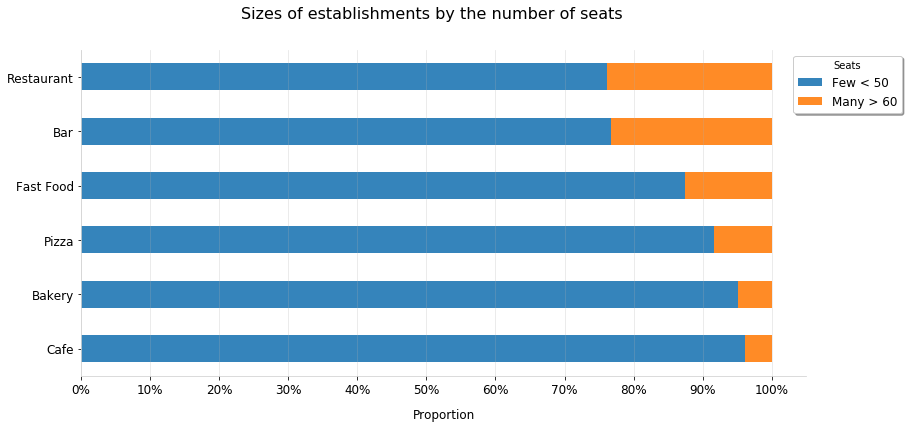

In [38]:
# plot a stacked bar chart to show the proportion of many and few seats in each category
fig, ax = plt.subplots(figsize=(13,6))
category_seats_pivot.plot.barh(stacked=True, ax=ax, alpha=.9)

#spines and grid
sns.despine()
plt.grid(False, axis='y')
plt.grid(axis='x', alpha=.3)
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')
plt.legend(['Few < 50', 'Many > 60'],
           shadow=True,
           fancybox=True,
           title='Seats',
           facecolor='white',
           fontsize=12,
           bbox_to_anchor=(0, 0, 1.14, 1))

#tick
ax.tick_params(labelsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(.10))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))

#labels and title
plt.ylabel('')
plt.xlabel('Proportion', labelpad=12, fontsize=12)
plt.suptitle("Sizes of establishments by the number of seats",fontsize=16)
plt.savefig('sizes of establishments.png')
plt.show()

In each category establishments with small number of seats are prevalent. Among restaurants and bars slightly less than 25% have a lot of seats and in cafes category only 4% of establishments have number of seats greater than 60.

#### Streets analysis<a id="streets"></a> 

- Put the data on street names from the address column in a separate column.
- Plot a graph of the top ten streets by number of restaurants.
- Find the number of streets that only have one restaurant.
- For streets with a lot of restaurants, look at the distribution of the number of seats.  What are the trends?

In [39]:
# define list with endings of streets
endings = ['BLVD','ST','AVE','RD','DR','WAY']

In [40]:
# define a function to get street name
def get_street(x):
    split_address = x.replace("#", "").replace("/", "").split()
    new = []
    for i in split_address:
        if i.isdigit():
            continue
        else:
            new.append(i)
    return ' '.join(new)

In [41]:
# define a function to filter the results with street names
def filters(extra):
    new= []
    y=extra.split(' ')
    for i in y:
        if i in endings and i != 'STE': 
            new.append(i)
            return " ".join(new)
        elif i == 'STE':
            return " ".join(new)
        new.append(i)
    return " ".join(new)                

In [42]:
# apply both functions to address column
data['street'] = data['address'].apply(lambda x: get_street(x)).apply(lambda x: filters(x))
data['street'] = data['street'].str.upper() # all street names capitalized

In [43]:
# final cleaning of the streets
data['street'] = data['street'].str.replace(r'(^.*S BROADWAY.*$)', 'S BROADWAY')
data['street'] = data['street'].str.replace(r'(^.*N BROADWAY.*$)', 'N BROADWAY')
data['street'] = data['street'].str.replace(r'(^BROADWAY.*$)', 'BROADWAY')
data['street'] = data['street'].str.replace(r'(^.*ASTRONAUT.*$)', 'ASTRONAUT E S ONIZUKA ST')
data['street'] = data['street'].str.replace(r'(^.*JAPANESE.*$)', 'JAPANESE VLG')
data['street'] = data['street'].str.replace(r'(^.*WESTWOOD.*$)', 'WESTWOOD')
data['street'] = data['street'].str.replace(r'(^.*CENTURY PARK.*$)', 'E CENTURY PARK')

# check result
data[data['street'].str.contains("BROADWAY")]['street'].value_counts()

S BROADWAY    123
N BROADWAY     77
BROADWAY       12
Name: street, dtype: int64

In [44]:
# show streets' names extracted from address
data['street'].sort_values().value_counts().head(10)

WILSHIRE BLVD        384
W SUNSET BLVD        369
W PICO BLVD          343
S WESTERN AVE        277
SANTA MONICA BLVD    262
HOLLYWOOD BLVD       242
W OLYMPIC BLVD       234
W 3RD ST             231
S FIGUEROA ST        228
W 6TH ST             214
Name: street, dtype: int64

In [45]:
# calculate number of establishments on each street and show top 10 streets
number = data.groupby('street',as_index=False)['id'].agg('count').\
              rename(columns={'id':'rest_quantity'}).\
              sort_values(by='rest_quantity',ascending=False)

number.nlargest(10,'rest_quantity')

,street,rest_quantity
720,WILSHIRE BLVD,384
688,W SUNSET BLVD,369
683,W PICO BLVD,343
542,S WESTERN AVE,277
553,SANTA MONICA BLVD,262
203,HOLLYWOOD BLVD,242
682,W OLYMPIC BLVD,234
614,W 3RD ST,231
459,S FIGUEROA ST,228
620,W 6TH ST,214


In [46]:
# create a list with street's names
top_10 =number.nlargest(10,'rest_quantity')['street'].tolist() 
top_10

['WILSHIRE BLVD',
 'W SUNSET BLVD',
 'W PICO BLVD',
 'S WESTERN AVE',
 'SANTA MONICA BLVD',
 'HOLLYWOOD BLVD',
 'W OLYMPIC BLVD',
 'W 3RD ST',
 'S FIGUEROA ST',
 'W 6TH ST']

In [47]:
# separate establishments to chain and non-chain types, get quantity 
top_10_data = data.query('street in @top_10').pivot_table(index='street',
                                                          values='id',columns='chain',
                                                          aggfunc='count',fill_value=0,
                                                          margins=True,margins_name='Total').reset_index()
top_10_data = top_10_data.iloc[:-1,:].sort_values(by='Total',ascending=False)
top_10_data.columns=['street','Non_chain','Chain','Total']
top_10_data

,street,Non_chain,Chain,Total
9,WILSHIRE BLVD,238,146,384
8,W SUNSET BLVD,232,137,369
7,W PICO BLVD,230,113,343
2,S WESTERN AVE,173,104,277
3,SANTA MONICA BLVD,158,104,262
0,HOLLYWOOD BLVD,160,82,242
6,W OLYMPIC BLVD,152,82,234
4,W 3RD ST,149,82,231
1,S FIGUEROA ST,131,97,228
5,W 6TH ST,142,72,214


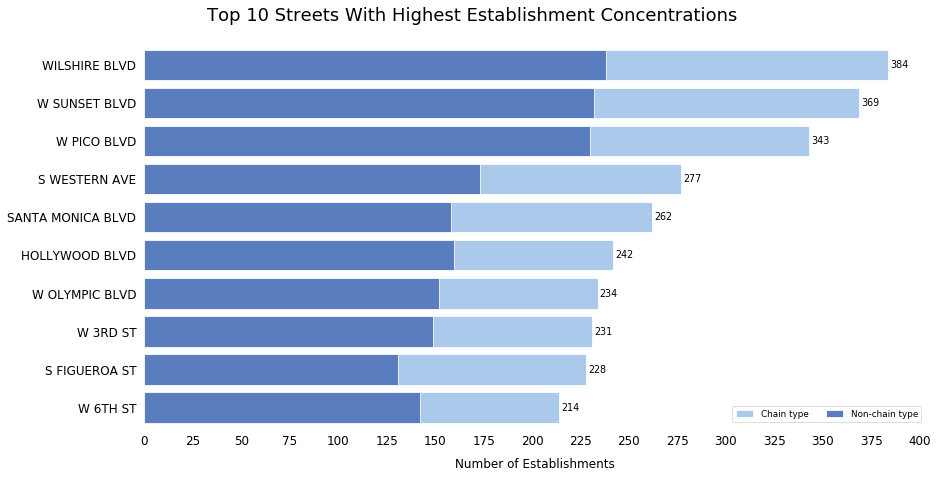

In [48]:
# plot a barchart showing top 10 streets and number of establishments 

sns.set_context('paper')
f, ax = plt.subplots(figsize = (14,7))
sns.set_color_codes('pastel')
#ax.set_facecolor("ghostwhite")
sns.barplot(x = 'Total', y = 'street', data = top_10_data,
            label = 'Chain type', color = 'b', edgecolor = 'w')
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment 
    
sns.set_color_codes('muted')
sns.barplot(x = 'Non_chain', y = 'street', data = top_10_data,
            label = 'Non-chain type', color = 'b', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'lower right')
sns.despine(left = True, bottom = True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.tick_params(axis='both', left=False, bottom=False, labelsize='12')
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')
plt.grid(False, axis='x')
plt.ylabel('', labelpad=15, fontsize=12)
plt.xlabel('Number of Establishments',labelpad=10,size=12)
plt.title("Top 10 Streets With Highest Establishment Concentrations",
          fontsize=18,
          x=.42,
          pad=25)
         
plt.savefig("top_10_streets.png")
plt.show()

Above mentioned streets have the highest establishment concentration: from 200 and up to almost 400 establishments on each. Planning to open a new establishment on these streets, there is need to be ready to a high competition. But at the same time high traffic of customers will be ensured on these streets. 

In [49]:
# find the number of streets wich have only 1 restaurants
print('The total number of streets:',len(number['street']))
print('Number of streets with 1 establishment:', len(number[number['rest_quantity']==1]))
print('Proportion of streets with 1 establishment:','{:.0%}'.format(
       len(number[number['rest_quantity']==1]) / 
       len(number['street'])))


The total number of streets: 732
Number of streets with 1 establishment: 321
Proportion of streets with 1 establishment: 44%


Out of all 732 streets analyzed 44% of them have only 1 establishment.

In [50]:
# calculate the number of each establishment type in each street 
streets_by_type_count = data.pivot_table(index=['street'],columns='object_type',\
                                         values='id',aggfunc='count',fill_value='',\
                                         margins=True,margins_name="Total").reset_index()
streets_by_type_count=streets_by_type_count.iloc[:-1,:]
streets_by_type_count.sort_values(by='Total',ascending=False)

object_type,street,Bakery,Bar,Cafe,Fast Food,Pizza,Restaurant,Total
720,WILSHIRE BLVD,5,10,24,25,11,309,384
688,W SUNSET BLVD,12,13,24,31,17,272,369
683,W PICO BLVD,13,11,13,31,18,257,343
542,S WESTERN AVE,10,5,9,24,10,219,277
553,SANTA MONICA BLVD,9,6,11,20,12,204,262
...,...,...,...,...,...,...,...,...
454,S DOHENY DR,,,,,,1,1
453,S CROCKER ST,,,,,,1,1
204,HOLMES AVE,,,,,,1,1
450,S COMMONWEALTH AVE,,,,,,1,1


In [51]:
print('The number of streets which have only one Restaurant is:',len(streets_by_type_count.query('Restaurant==1')))

The number of streets which have only one Restaurant is: 305


In [52]:
# list with the street's names which have only 1 restaurant
streets_by_type_count.query('Restaurant==1')['street'].sort_values().tolist()

['5TH ST',
 '7TH ST',
 'ABBOT KINNEY',
 'ACADEMY DR',
 'ALBANY ST',
 'ALLISON AVE',
 'ALLSTON ST',
 'ALTURA ST',
 'ARBOR VITAE ST',
 'AVENUE OF THE STARS A',
 'AVIATION BLVD',
 'BARHAM BLVD',
 'BARRINGTON AVE',
 'BARTON AVE',
 'BEATRICE ST',
 'BELLAGIO RD',
 'BEVERLY BLV',
 'BEVERWIL DR',
 'BISHOPS RD',
 'BLAINE ST',
 'BRADDOCK DR',
 'BUNDY DR',
 'CADILLAC AVE',
 'CALIFORNIA STATE ROUTE BLVD',
 'CAMPUS RD',
 'CENTURY BLVD',
 'CHARLIE SIFFORD DR',
 "CHILD'S WAY",
 'CLEARWATER ST',
 'CLINTON ST',
 'COLBY AVE',
 'CORDOVA ST',
 'CRESTVIEW DR',
 'DEVONSHIRE ST',
 'DEWEY AVE',
 'DOWNEY WAY',
 'DUNHAM ST',
 'E 10TH ST',
 'E 16TH ST',
 'E 18TH ST',
 'E 1ST BLVD',
 'E 37TH ST',
 'E 3RD PL',
 'E 42ND ST',
 'E 4TH PL',
 'E 58TH PL',
 'E 58TH ST',
 'E 7TH PL 101-3',
 'E 9TH AVE',
 'E 9TH PL',
 'E CAHUENGA BLVD',
 'E CESAR E CHAVEZ',
 'E CHARLES E YOUNG DR',
 'E COMMERCIAL ST',
 'E JEFFERSON AVE',
 'E MARTIN LUTHER KING JR BLVD',
 'E OBSERVATORY AVE',
 'E OLVERA ST',
 'E PASEO DE LA PLZ',
 'E POMON

Some streets can really have only one restaurant, for example: 5TH ST, 7TH ST, BELLAGIO RD, etc. But from the other hand, there are inaccurate data in address column, some streets have different spelling, mistakes in spelling or zeroes instead of letters 'OO': like MILLENIUM DR and MILLENNIUM DR, GRIFFIN AVE and GRIFFITH AVE, IMPERIAL HWY and IMPERIAL ST, JAMES M. WOOD BLVD and JAMES WOOD BLVD, Z00 DR and ZOO DR. This is the reason why such streets were counted only once.


In [53]:
# since we are interested in Cafe type category, let's find streets wich have a big number of establishments, but only 1 Cafe
streets_by_type_count[streets_by_type_count['Cafe']==1].sort_values(by='Total',ascending=False).head(10)

object_type,street,Bakery,Bar,Cafe,Fast Food,Pizza,Restaurant,Total
95,E 1ST ST,7,3,1,11,4,85,111
297,N BROADWAY,7,,1,8,,61,77
121,E CESAR E CHAVEZ AVE,4,2,1,12,6,46,71
695,W WASHINGTON BLVD,6,,1,9,4,49,69
494,S MAIN ST,3,3,1,3,,53,63
556,SAWTELLE BLVD,1,1,1,5,,47,55
726,YORK BLVD,,2,1,7,2,38,50
629,W ADAMS BLVD,2,,1,3,1,36,43
73,CRENSHAW BLVD,,1,1,11,3,27,43
369,N VINE ST,,2,1,4,,35,42


Above mentioned streets are good to open a Cafe. High customer traffic and low concurention.

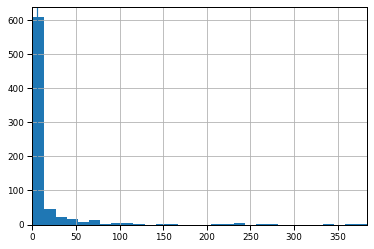

In [54]:
# look at the distribution of establishments to define category "a lot" of establishments
# and separate streets into two groups 'few' and 'many' establishments number
streets_by_type_count['Total'].hist(bins=30)
plt.axvline(streets_by_type_count['Total'].quantile(.68))
plt.xlim(0,streets_by_type_count['Total'].max())
plt.show()

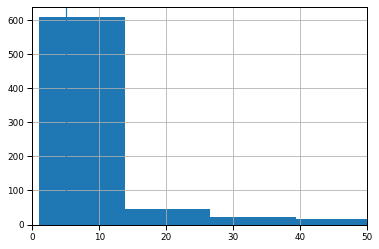

In [55]:
# the same plot with x- axis limit to 50
streets_by_type_count['Total'].hist(bins=30)
plt.axvline(streets_by_type_count['Total'].quantile(.68))
plt.xlim(0,50)
plt.show()

We can conclude that streets which have more than 10 establishments are streets with many establishments, and others - few.

In [56]:
# calculate proportion
less_10 = streets_by_type_count.query('Total<=10')['Total']
more_10 = streets_by_type_count.query('Total>10')['Total']            
print("Less or 10:",len(less_10))
print("More than 10:",len(more_10))
print("More than 10_%:",'{:.0%}'.format(len(more_10)/len(streets_by_type_count['Total'])))

Less or 10: 582
More than 10: 150
More than 10_%: 20%


From all streets only 20% have more than 10 establishments.

In [57]:
# list of streets with a lot of establishments
more_10_streets = streets_by_type_count.query('Total>10')['street'].unique()

In [58]:
# number of seats in establishments on streets from upper mentioned category 
top_number_seats = data.query('street in @more_10_streets')


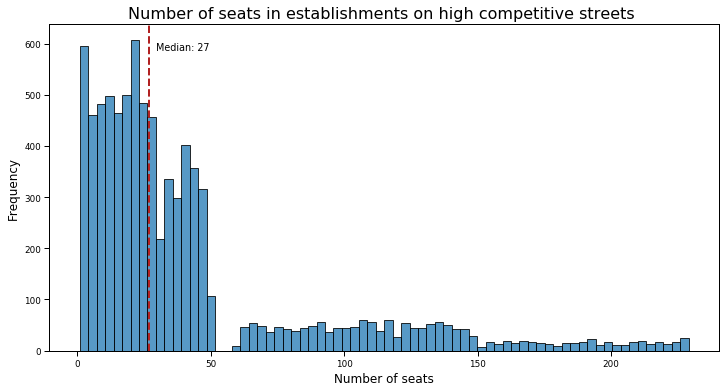

In [59]:
# plot a graph with the distribution of seats
plt.figure(figsize = (12,6))
sns.histplot(top_number_seats['number'], bins='auto')
plt.axvline(top_number_seats['number'].median(), color='firebrick', linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(top_number_seats['number'].median()*1.1, max_ylim*0.92, 'Median: {:.0f}'.format(top_number_seats['number'].median()))
plt.xlabel("Number of seats", fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title('Number of seats in establishments on high competitive streets ', size = 16)
plt.savefig('seats_top_streets.png')
plt.show()

The distribution of the number of seats in establishments located on high comtetitive streets have the same pattern as the overall distribution of seats we saw earlier. But an average number of seat on these top streets is slightly bigger - 27.

In [60]:
# have a look on distribution of seats in chain and non chain establishments on these streets
top_number_seats_chain = data.query('street in @more_10_streets and chain==True')
top_number_seats_non_chain = data.query('street in @more_10_streets and chain==False')

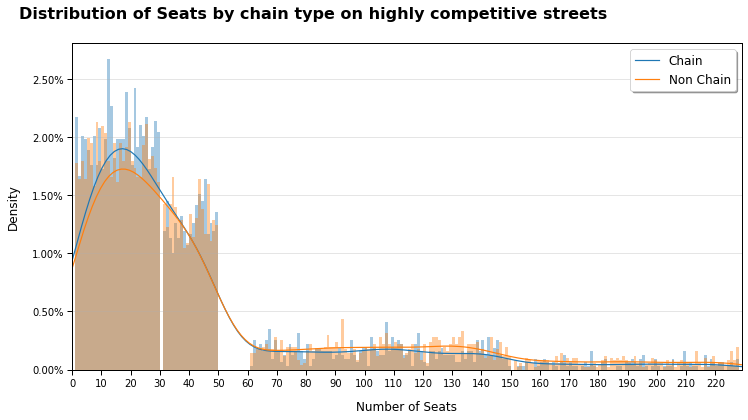

In [61]:
# plot a density graph
fig, ax = plt.subplots(figsize=(12,6), facecolor='white')
sns.distplot(top_number_seats_chain['number'], bins=range(1,top_number_seats['number'].max()))
sns.distplot(top_number_seats_non_chain['number'], bins=range(1,top_number_seats['number'].max()))

def mjrFormatter(x, pos):
    return "{:.2f}%".format(x * 100)
plt.grid(False, axis='x')
plt.grid(axis='y',alpha=.4)
plt.xlim(0, top_number_seats['number'].max())
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.tick_params(labelsize=10)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(mjrFormatter))

plt.legend(['Chain', 'Non Chain'], fancybox=True, shadow=True, fontsize=12,facecolor='white')

plt.xlabel('Number of Seats', labelpad=12, fontsize=12)
plt.ylabel('Density', labelpad=12, fontsize=12)
plt.title(
    "Distribution of Seats by chain type on highly competitive streets",
    fontsize=16,
    x=-.08,
    pad=25,
    ha='left',
    fontweight='semibold')

plt.savefig('seats_dis.png')
plt.show()

On streets with a large number of establishments there are more chain type establishments with small number of seats in category 'few' seats. But non chain type establishments in this category have larger establishments - 28 seats on average. There are more non chain tipes establishments in category 'many' seats.

### Conclusion<a id="conclusion"></a> 

According to market research of restaurant business in Los Angeles, there are more than 9650 establishments, most of them are non chain types - about 62%.  The main market share is occupied by restaurants - over 75%, while cafes have only 4.5%. Moreover 61% are chain type. That means there are good conditions to enter the market with a novelty robot-run cafe: the cafe niche is not as competitive as the restaurants and there is potential for growth to a chain. Chain typed establishments in LA are characterized by a big number of restaurants with a few seats. So the robot-run cafe should not be large, an average size of cafes in LA is about 25 seats.

Among all streets in LA which were analyzed (more than 700) only 20% have more than 10 establishments. These streets could be a good choice for a new novelty cafe, as there are a high customer traffic there. But at the same time among these highly competitive streets there are some which have a small number of cafes. It will help to avoid competition with 'big players' among cafe's chains. On the other hand there are streets which have only 1 food type establishmet or don't have cafes at all. 

To sum up, large share of establishments in LA, especially considering their high persent of non-chain establishments make it relatively easy to compete and thrive given into account the novelty of robot-run service. The company should consider starting off as a non-chain with 25 seats and depending on its strategy, establish itself in a street with many restaurants and/or one restaurant. It can then aggressively grow and establish a chain thereafter given the novelty of service provided. 

[Go back to the Table of Contents](#table_of_contents)

Link to the presentation <a href="https://drive.google.com/file/d/1u_FOLWwHCHfvNVuaM_oBv5Uc0N6-ZSMK/view?usp=sharing">here</a>
<a class="anchor" id="presentation"></a> 